# Unsupervised Learning
## Autoencoders
Autoencoders are a dimensionality reduction technique for neural networks.

In [1]:
import h2o
import matplotlib.pyplot as plt
%matplotlib inline
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from C:\Users\a.nogue.sanchez\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ANOGUE~1.SAN\AppData\Local\Temp\tmp3sp63kba
  JVM stdout: C:\Users\ANOGUE~1.SAN\AppData\Local\Temp\tmp3sp63kba\h2o_a_nogue_sanchez_started_from_python.out
  JVM stderr: C:\Users\ANOGUE~1.SAN\AppData\Local\Temp\tmp3sp63kba\h2o_a_nogue_sanchez_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Europe/Paris
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,4 months and 3 days !!!
H2O cluster name:,H2O_from_python_a_nogue_sanchez_p7ambc
H2O cluster total nodes:,1
H2O cluster free memory:,3.533 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


Load the iris dataset

In [3]:
url = 'http://h2o-public-test-data.s3.amazonaws.com/smalldata/iris/iris_wheader.csv'
iris = h2o.import_file(url)

Parse progress: |█████████████████████████████████████████████████████████| 100%


Split into train an test set

In [4]:
train, test = iris.split_frame([0.8], seed = 123)

In [10]:
x = ['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid']

In [16]:
iris.columns

['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']

Auto Encoder model

In [11]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator

In [12]:
my_AE = H2OAutoEncoderEstimator(
    hidden = [4],
    activation = 'Tanh',
    epochs = 300,
    model_id = 'AutoEncored_4',
    train_samples_per_iteration = train.nrow,
    score_interval = 0,
    score_duty_cycle = 1.0)
%time my_AE.train(x, None, train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Wall time: 1.26 s


Scoring history to see the different epochs' results

In [17]:
sh = my_AE.score_history()
sh.head()

,,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse
0,,2019-08-04 09:37:08,0.163 sec,"0,00000 obs/sec",0.0,0,0.0,0.337410,0.113845
1,,2019-08-04 09:37:08,0.219 sec,2218 obs/sec,1.0,1,122.0,0.289039,0.083544
2,,2019-08-04 09:37:08,0.226 sec,3935 obs/sec,2.0,2,244.0,0.239578,0.057398
3,,2019-08-04 09:37:08,0.255 sec,6931 obs/sec,5.0,5,610.0,0.145152,0.021069
4,,2019-08-04 09:37:08,0.265 sec,7625 obs/sec,6.0,6,732.0,0.133030,0.017697


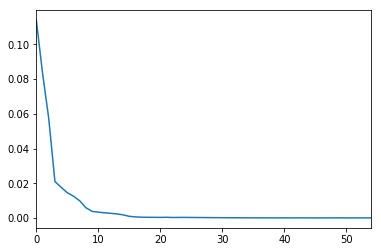

In [18]:
sh['training_mse'].plot()

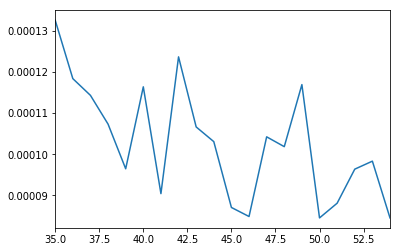

In [21]:
sh['training_mse'].tail(20).plot()

We can see that even if the mse score looked flat at last epochs, it keeps improving accurary. Means that our default early stopping stopped the algorithm too early. Let's re-train the algorithm with 15 as early stopping now.

In [22]:
my_AE = H2OAutoEncoderEstimator(
    hidden = [4],
    activation = 'Tanh',
    epochs = 300,
    model_id = 'AutoEncored_4',
    train_samples_per_iteration = train.nrow,
    score_interval = 0,
    score_duty_cycle = 1.0,
    stopping_rounds = 15)
%time my_AE.train(x, None, train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Wall time: 1.15 s


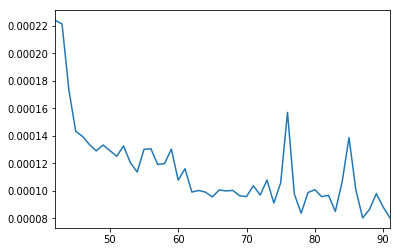

In [24]:
sh = my_AE.score_history()
sh['training_mse'].tail(50).plot()

Auto Encoders tend to be fast to learn as we have few nodes in the hidden layers

## Multiple layers

In [31]:
my_AE_multiple = H2OAutoEncoderEstimator(
    hidden = [5,3,5],
    activation = 'Tanh',
    epochs = 300,
    model_id = 'AutoEncored_4',
    train_samples_per_iteration = train.nrow,
    score_interval = 0,
    score_duty_cycle = 1.0,
    stopping_rounds = 15)
%time my_AE_multiple.train(x, None, train)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Wall time: 675 ms


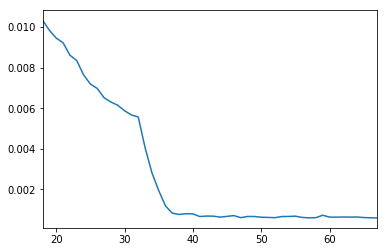

In [32]:
sh = my_AE_multiple.score_history()
sh['training_mse'].tail(50).plot()

## Anomalies

The aim is to see which elements of the dataset where the most difficult to learn, so that they might be an exception or anomaly to care about

In [35]:
x = iris.columns
my_AE_anomaly = H2OAutoEncoderEstimator(
    hidden = [16], # the aim here is not to reduce dimensionality but to learn well the data
    activation = 'Tanh',
    epochs = 300,
    model_id = 'AutoEncored_4',
    train_samples_per_iteration = train.nrow,
    score_interval = 0,
    score_duty_cycle = 1.0,
    stopping_rounds = 15)
%time my_AE_anomaly.train(x, None, iris)

deeplearning Model Build progress: |██████████████████████████████████████| 100%
Wall time: 864 ms


We get anomalies with the function anomaly on the dataset

In [38]:
anomalies = my_AE_anomaly.anomaly(iris).cbind(iris).as_data_frame()
s = anomalies.sort_values("Reconstruction.MSE",ascending=False)

There are the most anormal flours

In [39]:
s.head()

,Reconstruction.MSE,sepal_len,sepal_wid,petal_len,petal_wid,class
15,0.000268,5.7,4.4,1.5,0.4,Iris-setosa
131,0.000250,7.9,3.8,6.4,2.0,Iris-virginica
106,0.000166,4.9,2.5,4.5,1.7,Iris-virginica
135,0.000145,7.7,3.0,6.1,2.3,Iris-virginica
41,0.000109,4.5,2.3,1.3,0.3,Iris-setosa


And these are the more typical (i.e. easy to learn flours)

In [41]:
s.tail()

,Reconstruction.MSE,sepal_len,sepal_wid,petal_len,petal_wid,class
48,1.031942e-06,5.3,3.7,1.5,0.2,Iris-setosa
27,9.623539e-07,5.2,3.5,1.5,0.2,Iris-setosa
39,8.089546e-07,5.1,3.4,1.5,0.2,Iris-setosa
86,6.891529e-07,6.7,3.1,4.7,1.5,Iris-versicolor
7,5.166023e-07,5.0,3.4,1.5,0.2,Iris-setosa
